# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [15]:
!git clone https://github.com/geomags3/cvr_course.git

fatal: destination path 'cvr_course' already exists and is not an empty directory.


In [25]:
from pathlib import Path
import numpy as np
import cv2
import math
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)

from ipywidgets import interact
import ipywidgets as widgets

In [22]:
# Path to the arrow images
arrows_folder = Path('/content/cvr_course/data/imgs/arrow')
# List of arrow images
arrow_files = [file.name for file in arrows_folder.iterdir()]

### Чтение изображений

In [24]:
@interact(file=arrow_files)
def show_files(file):
  img = cv2.imread(str(arrows_folder/file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

interactive(children=(Dropdown(description='file', options=('vlcsnap-2020-10-21-18h01m27s294.png', 'vlcsnap-20…

### Определение расстояния до листа

In [268]:
def find_contour(img, low_th, high_th):
  # Apply filter to smooth the image and highlight contours
  smooth_img = cv2.bilateralFilter(img, 15, 75, 75)
  # Get the sheet's mask
  mask = cv2.inRange(smooth_img, low_th, high_th)

  # Find contours
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Filter contours and pick the largest one
  areas = []
  for contour in contours:
    areas.append(cv2.contourArea(contour))

  max_contour_idx = areas.index(max(areas))
  contour = contours[max_contour_idx]

  # Approximate contour to find external points
  epsilon = 0.05 * cv2.arcLength(contour, True)  # 0.01
  approx = cv2.approxPolyDP(contour, epsilon, True)

  approx = cv2.convexHull(approx)

  return mask, contour, approx


In [269]:
@interact(file=arrow_files)
def find_distance(file):
  img = cv2.imread(str(arrows_folder/file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  low_th = (170, 170, 170)
  high_th = (255, 255, 255)

  _, contour, approx = find_contour(img, low_th, high_th)

  verbose_img = img.copy()
  cv2.drawContours(verbose_img, [contour], -1, (255, 0, 0), 1)
  cv2.drawContours(verbose_img, [approx], -1, (0, 0, 255), 2)

  length = cv2.arcLength(approx, True)
  dist = 180.0 * 364 / length

  if len(approx) > 4:
    print(f'Unable to detect the sheet fully.\nApproximate distance: >{dist:.2f}mm')
  elif len(approx) == 4:
    print(f'Distance: {dist:.2f}mm')
  else:
    print('Unable to detect the sheet')

  plt.imshow(verbose_img)
  plt.axis('off')
  plt.show()

interactive(children=(Dropdown(description='file', options=('vlcsnap-2020-10-21-18h01m27s294.png', 'vlcsnap-20…

### Приведение изображения листка к "виду сверху"

In [179]:
# def order_points(pts):
#     # initialzie a list of coordinates that will be ordered
#     # such that the first entry in the list is the top-left,
#     # the second entry is the top-right, the third is the
#     # bottom-right, and the fourth is the bottom-left
#     rect = np.zeros((4, 2), dtype="float32")
    
#     # the top-left point will have the smallest sum, whereas
#     # the bottom-right point will have the largest sum
#     s = pts.sum(axis=1)
#     print(s)
#     print(np.argmin(s))
#     print(np.argmax(s))
#     rect[0] = pts[np.argmin(s)]
#     rect[2] = pts[np.argmax(s)]
    
#     # now, compute the difference between the points, the
#     # top-right point will have the smallest difference,
#     # whereas the bottom-left will have the largest difference
#     diff = np.diff(pts, axis=1)
#     print(diff)
#     print(np.argmin(diff))
#     print(np.argmax(diff))
#     rect[1] = pts[np.argmin(diff)]
#     rect[3] = pts[np.argmax(diff)]
    
#     # return the ordered coordinates
#     return rect

In [254]:
def order_points_2(pts):
  # points = pts.copy()
  s = points.sum(axis=1)

  tl_idx = np.argmin(s)
  ptr = -len(points) + tl_idx

  first = points[ptr : ]
  second = points[ : ptr]

  return np.concatenate((first, second)).astype(np.float32)

In [305]:
def direction(img):
  high_th = (220, 205, 220)
  low_th = (0, 0, 0)

  smooth_img = cv2.bilateralFilter(img, 15, 75, 75)
  # Get the sheet's mask
  mask = cv2.inRange(smooth_img, low_th, high_th)

  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Filter contours and pick the largest one
  areas = []
  for contour in contours:
    areas.append(cv2.contourArea(contour))

  max_contour_idx = areas.index(max(areas))
  contour = contours[max_contour_idx]

  # get arrow mass center
  M = cv2.moments(contour)
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  x, y, w, h = cv2.boundingRect(contour)
  bbox = (x, y, w, h)

  if w < h:
    if cy - y > h // 2:
      arrow_dir = 'down'
    else:
      arrow_dir = 'up'
  
  else:
    if cx - x > w // 2:
      arrow_dir = 'right'
    else:
      arrow_dir = 'left'

  return mask, contour, bbox, arrow_dir

In [377]:
@interact(file=arrow_files)
def warp_arrow(file):
  img = cv2.imread(str(arrows_folder/file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  low_th = (170, 170, 170)
  high_th = (255, 255, 255)

  _, contour, approx = find_contour(img, low_th, high_th)

  verbose_img = img.copy()
  cv2.drawContours(verbose_img, [contour], -1, (255, 0, 0), 1)
  cv2.drawContours(verbose_img, [approx], -1, (0, 0, 255), 2)

  # plt.figure(figsize=(20, 6))
  fig, ax = plt.subplots(1, 3, figsize=(20, 10))
  
  ax[0].imshow(verbose_img)
  ax[0].axis('off')

  if len(approx) == 4:
    # print(f'points\n{approx}')
    rect = order_points_2(approx[:, 0, :])
    # print(f'\nshift points\n{rect}')
    (tl, tr, br, bl) = rect

    sides = [
             np.array((tr, tl)),
             np.array((tl, bl)),
             np.array((bl, br)),
             np.array((br, tr))
    ]
    # print(sides)

    sides_length = [cv2.arcLength(side, False) for side in sides]
    # print(sides_length)

    max_side = int(max(sides_length))
    max_side = 480 # 200
    # print(max_side)

    dst = np.array([
                   [0, 0],
                   [max_side - 1, 0],
                   [max_side - 1, max_side - 1],
                   [0, max_side - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    # print(M)
    warped = cv2.warpPerspective(img, M, (max_side, max_side))

    

    warped_mask, arrow_cnt, bbox, arrow_dir = direction(warped)
    x, y, w, h = bbox
    cv2.rectangle(warped, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(warped, arrow_dir, (5, 20), cv2.FONT_HERSHEY_COMPLEX, 0.8,
                (0, 0, 255), 1, cv2.LINE_AA, False)
    print(f'Arrow direction: {arrow_dir}')

    ax[1].imshow(warped)
    ax[1].axis('off')

    ax[2].imshow(warped_mask)
    ax[2].axis('off')
  
  else:
    print('Unable to detect the sheet')
    ax[1].imshow(verbose_img)
    ax[1].axis('off')
  
  plt.show()

interactive(children=(Dropdown(description='file', options=('vlcsnap-2020-10-21-18h01m27s294.png', 'vlcsnap-20…

## Обработка видео

In [320]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [373]:
def warp_image(img):
  # img = cv2.imread(str(arrows_folder/file))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  low_th = (170, 170, 170)
  high_th = (255, 255, 255)

  _, contour, approx = find_contour(img, low_th, high_th)

  verbose_img = img.copy()
  cv2.drawContours(verbose_img, [contour], -1, (255, 0, 0), 1)
  cv2.drawContours(verbose_img, [approx], -1, (0, 0, 255), 2)

  # plt.figure(figsize=(20, 6))
  # fig, ax = plt.subplots(1, 3, figsize=(20, 10))
  
  # ax[0].imshow(verbose_img)
  # ax[0].axis('off')

  if len(approx) == 4:
    # print(f'points\n{approx}')
    rect = order_points_2(approx[:, 0, :])
    # print(f'\nshift points\n{rect}')
    (tl, tr, br, bl) = rect

    sides = [
             np.array((tr, tl)),
             np.array((tl, bl)),
             np.array((bl, br)),
             np.array((br, tr))
    ]
    # print(sides)

    sides_length = [cv2.arcLength(side, False) for side in sides]
    # print(sides_length)

    max_side = int(max(sides_length))
    max_side = 480 # 200
    # print(max_side)

    dst = np.array([
                   [0, 0],
                   [max_side - 1, 0],
                   [max_side - 1, max_side - 1],
                   [0, max_side - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    # print(M)
    warped = cv2.warpPerspective(img, M, (max_side, max_side))

    

    warped_mask, arrow_cnt, bbox, arrow_dir = direction(warped)
    x, y, w, h = bbox
    cv2.rectangle(warped, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(warped, arrow_dir, (5, 20), cv2.FONT_HERSHEY_COMPLEX, 0.8,
                (0, 0, 255), 1, cv2.LINE_AA, False)
    
    # ax[1].imshow(warped)
    # ax[1].axis('off')

    # ax[2].imshow(warped_mask)
    # ax[2].axis('off')
    # print(warped.shape)

    return cv2.hconcat([verbose_img, warped])

    
  
  else:
    print('Unable to detect the sheet')
    # ax[1].imshow(verbose_img)
    # ax[1].axis('off')
  return None
  # plt.show()

/content/cvr_course/data/imgs/arrow/vlcsnap-2020-10-21-18h01m51s638.png


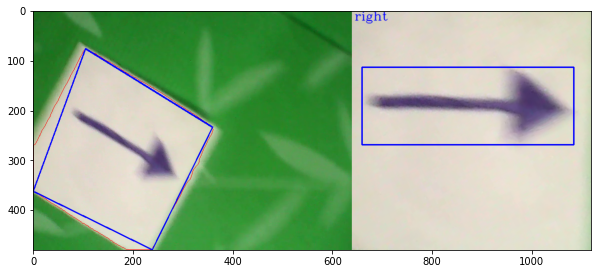

In [374]:
img1_file = str(arrows_folder/arrow_files[1])
print(img1_file)
img1 = cv2.imread(img1_file)

img1_out = warp_image(img1)

plt.imshow(img1_out)
plt.show()

In [375]:
from moviepy.editor import VideoFileClip

In [ ]:
video_file = Path('/content/drive/My Drive/cvr_cource/3.mp4')
output_file = Path('/content/drive/My Drive/cvr_cource/output.mp4')

clip = VideoFileClip(str(video_file))
output = clip.fl_image(warp_image)
output.write_videofile(str(output_file), audio=False)

[Ссылка на видео](https://drive.google.com/file/d/1--jmVtydTya3y8VF8wsXURpP-cW4j9Yj/view?usp=sharing)